<a href="https://colab.research.google.com/github/Madiha64/Madiha-CV-cat-dog-cnn/blob/main/vlms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [ ]:
# Install necessary libraries
!pip install torch torchvision transformers roboflow
from sklearn.metrics import precision_score, recall_score, f1_score
!pip install torch torchvision transformers roboflow tqdm scikit-learn
import torch
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor
from roboflow import Roboflow
import os
import torch
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor
from roboflow import Roboflow
from torch.utils.data import DataLoader, Dataset
import os
import json
from PIL import Image
import numpy as np
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
import os
import json
from PIL import Image
import cv2
from tqdm import tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 122.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.9/86.9 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
from roboflow import Roboflow

rf = Roboflow(api_key="Md29cWfzX6FKw6DNPDgf")
project = rf.workspace("rebar-exposure-and-spalling").project("aperi")
version = project.version(1)
dataset = version.download("coco-segmentation")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to aperi-1 in coco-segmentation:: 100%|██████████| 2073/2073 [00:00<00:00, 4981.84it/s]


In [ ]:
# folders where the data
import os

base_dir = "/content/aperi-1"
print("Train folder:", os.listdir(os.path.join(base_dir, "train")))
print("Valid folder:", os.listdir(os.path.join(base_dir, "valid")))

Train folder: ['32439305_jpg.rf.632b627a061c3567140358cbb0b50f83.jpg', '70_jpg.rf.5487dc90cc1a5b1dc5ba1fad686c9fc4.jpg', '504_jpg.rf.6a1ca4ef33e366ff94d2f23eba0baeb2.jpg', '115_jpg.rf.23cd516a7f2375a46a5d81bb6bff1a83.jpg', '560_jpg.rf.fd05f6144abfaab4501cf05a21d892f3.jpg', '96_jpg.rf.2cb4cd47ad44a59794bd9843e053ab92.jpg', '89_jpg.rf.2a074a0984c782ccc5a2b520c0e2cb23.jpg', '100_jpg.rf.3563e64a053a73cd5e264315f4bcd829.jpg', '525_jpg.rf.0ffb709c0c9caaf8599feb06ce638a14.jpg', '39_jpg.rf.a3cec1f73405a087ca9217081bf65c58.jpg', '9584061_jpg.rf.ba2e9a8783b7ccdc58229a1914434168.jpg', '9583745_jpg.rf.0806fe9b7d73a94abf2222b989f02f5a.jpg', '32439001_jpg.rf.728da5013e476cf60d70d82da9eb57fa.jpg', '397_jpg.rf.303a43b412680e04d901dc25481242e8.jpg', '157_jpg.rf.c27b2678d8d6b845cec319835661850c.jpg', '420_jpg.rf.2191cadcace67780f6566ffc7fac3411.jpg', '437_jpg.rf.376e1cf07b96dc1f21985f14d04b1b29.jpg', '9583693_jpg.rf.9b304a1010fd65c12b63d84706cd3be5.jpg', '347_jpg.rf.2aed85c08e8ef5fea87ccda869d5f664.jpg'

#json file convert into the mask

In [ ]:
import os
import json
import numpy as np
from pycocotools.coco import COCO
from pycocotools import mask as maskUtils
from PIL import Image

def coco_to_masks(coco_json_path, images_dir, masks_dir):
    os.makedirs(masks_dir, exist_ok=True)

    coco = COCO(coco_json_path)
    img_ids = coco.getImgIds()

    for img_id in img_ids:
        img_info = coco.loadImgs(img_id)[0]
        img_name = img_info['file_name']
        width, height = img_info['width'], img_info['height']

        # Initialize mask image (height x width) with background 0
        mask = np.zeros((height, width), dtype=np.uint8)

        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)

        for ann in anns:
            class_id = ann['category_id']  # You may want to map category IDs if needed
            seg = ann['segmentation']

            if type(seg) == list:
                # Polygon
                rles = maskUtils.frPyObjects(seg, height, width)
                rle = maskUtils.merge(rles)
            elif type(seg['counts']) == list:
                # Uncompressed RLE
                rle = maskUtils.frPyObjects(seg, height, width)
            else:
                # RLE
                rle = seg

            m = maskUtils.decode(rle)
            mask[m == 1] = class_id

        # Save mask as PNG
        mask_img = Image.fromarray(mask)
        mask_filename = os.path.splitext(img_name)[0] + '.png'
        mask_img.save(os.path.join(masks_dir, mask_filename))

    print("Mask images saved to", masks_dir)


In [ ]:
#generate the train_mask
coco_json_path = "/content/aperi-1/train/_annotations.coco.json"
images_dir = "/content/aperi-1/train"
masks_dir = "/content/aperi-1/train_masks"

coco_to_masks(coco_json_path, images_dir, masks_dir)

loading annotations into memory...
Done (t=0.26s)
creating index...
index created!
Mask images saved to /content/aperi-1/train_masks


In [ ]:
#generate the valid_mask
coco_json_path = "/content/aperi-1/valid/_annotations.coco.json"
images_dir = "/content/aperi-1/valid"
masks_dir = "/content/aperi-1/valid_masks"

coco_to_masks(coco_json_path, images_dir, masks_dir)

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Mask images saved to /content/aperi-1/valid_masks


**images vs masks**

In [ ]:
import os

image_dir = "/content/aperi-1/train"
mask_dir = "/content/aperi-1/train_masks"  # assuming masks are here too

# List image and mask files
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])
mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('.png')])

print("Images:", image_files[:5])
print("Masks:", mask_files[:5])

Images: ['100_jpg.rf.34e54dff0f77c9f6e5685b037353fd46.jpg', '100_jpg.rf.3563e64a053a73cd5e264315f4bcd829.jpg', '101_jpg.rf.34cfb18c3b156a642b2695659cf58d0d.jpg', '101_jpg.rf.845d3e8914bce0d40f36ab701158e097.jpg', '102_jpg.rf.94ab5b6bf26990c2f403501ebe8678f3.jpg']
Masks: ['100_jpg.rf.34e54dff0f77c9f6e5685b037353fd46.png', '100_jpg.rf.3563e64a053a73cd5e264315f4bcd829.png', '101_jpg.rf.34cfb18c3b156a642b2695659cf58d0d.png', '101_jpg.rf.845d3e8914bce0d40f36ab701158e097.png', '102_jpg.rf.94ab5b6bf26990c2f403501ebe8678f3.png']


**check image and masks  length**

In [ ]:
import os

image_dir = '/content/aperi-1/train'
mask_dir = '/content/aperi-1/train_masks'

images = sorted(os.listdir(image_dir))
masks = sorted(os.listdir(mask_dir))

print(f"Number of images: {len(images)}")
print(f"Number of masks: {len(masks)}")


Number of images: 1861
Number of masks: 1860


In [ ]:
# to check which images does not have the mask
import os

image_dir = '/content/aperi-1/train'
mask_dir = '/content/aperi-1/train_masks'

images = sorted(os.listdir(image_dir))
masks = sorted(os.listdir(mask_dir))

image_basenames = set(os.path.splitext(f)[0] for f in images)
mask_basenames = set(os.path.splitext(f)[0] for f in masks)

missing_masks = image_basenames - mask_basenames
print("Images missing masks:", missing_masks)

Images missing masks: {'_annotations.coco'}


In [ ]:
#After removing checking the length of train and train_masks are equal
import os

image_dir = '/content/aperi-1/train'
mask_dir = '/content/aperi-1/train_masks'

images = [f for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
masks = [f for f in os.listdir(mask_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

print(f"Number of images: {len(images)}")
print(f"Number of masks: {len(masks)}")

missing_masks = set(images) - set(masks)
if missing_masks:
    print(f"Images missing masks: {missing_masks}")
else:
    print("All images have corresponding masks!")


Number of images: 1860
Number of masks: 1860
Images missing masks: {'542_jpg.rf.c134a2870ab2158484928abe886c7708.jpg', '9584014_jpg.rf.0f90aa605446f65b3f95b21c88830016.jpg', '32439111_jpg.rf.8ecd065a0c1f7acc7af5abaf7a83bf5d.jpg', '496_jpg.rf.fabd08d535486e4b03404ae6f909d4c4.jpg', '32439322_jpg.rf.5f5dd7a0b6abc3361747bd661e81521e.jpg', '140_jpg.rf.7338f73e10c234684d6a6fb2c78cabc8.jpg', '32439031_jpg.rf.fafde72aa32aa2d7ab842da150385b23.jpg', '326_jpg.rf.0cf1c8ba62c904d1f684a46cf4e5c783.jpg', '404_jpg.rf.9c07d950795623ba77164b9198c5a1f0.jpg', '402_jpg.rf.4de7605914f1e6cf26aa1abcab6429c9.jpg', '9583676_jpg.rf.7fd29d32c50360854c916530e7f7ceb8.jpg', '9583741_jpg.rf.535ef4309c42aeb8bf19ecb7c8358ba1.jpg', '506_jpg.rf.446d17b74ec02246f9868404ad89620f.jpg', '475_jpg.rf.304ba336280f635daf6790dfb3328597.jpg', '32439222_jpg.rf.ee2bca77dac4c97bdd61e0f8d23c710a.jpg', '591_jpg.rf.83f8a04e1c81628fb29c313ab5f6e1d5.jpg', '159_jpg.rf.5673a4ebcc879296c7bfb42ac4b26e76.jpg', '32439004_jpg.rf.04999d5f2a164415

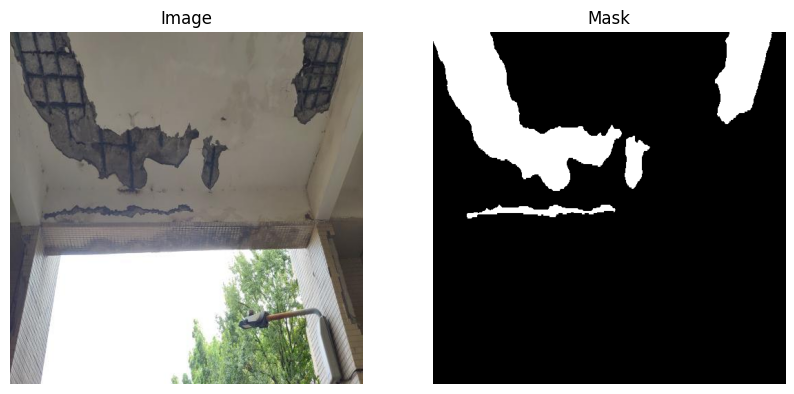

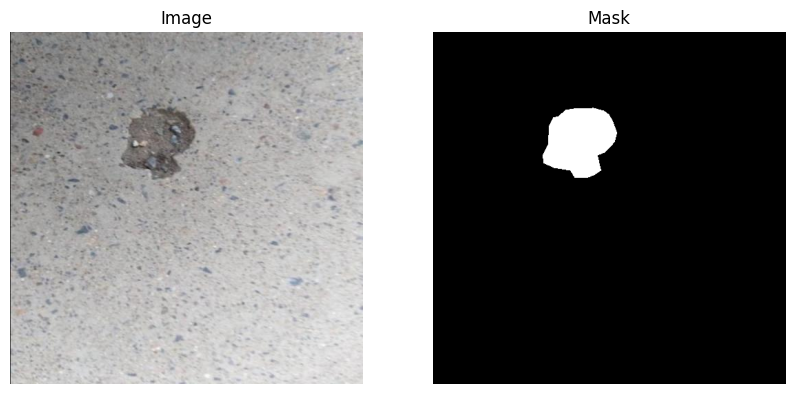

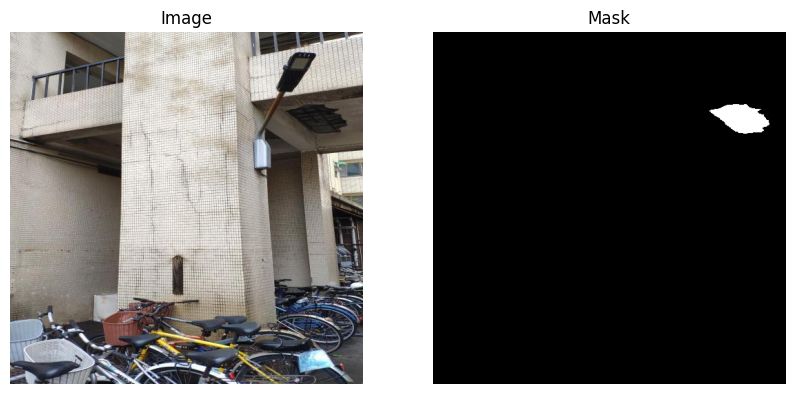

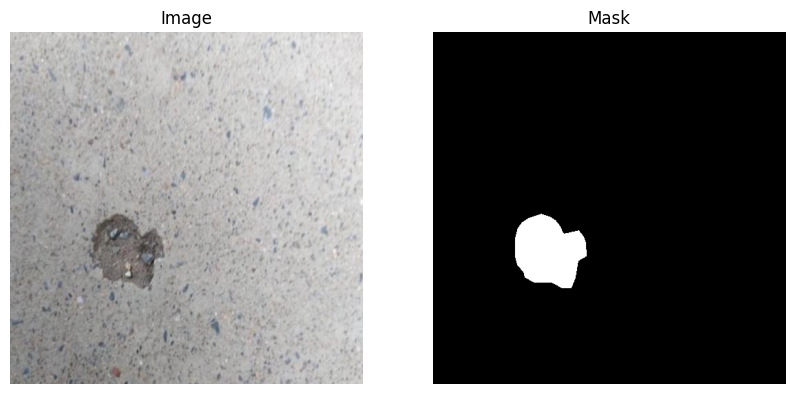

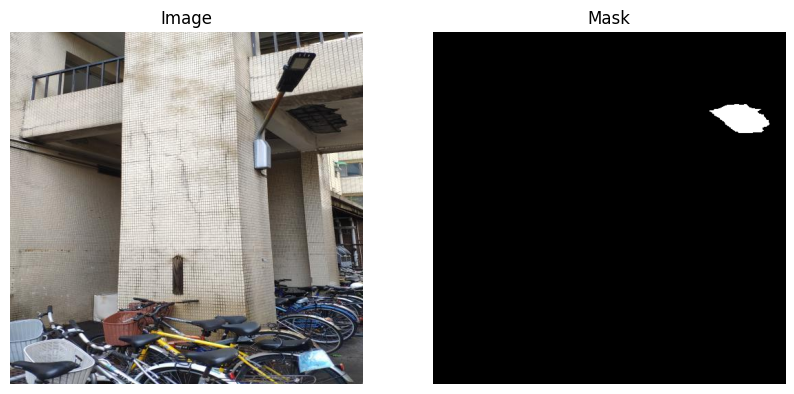

In [ ]:

# check the images corresponds to masks
import cv2
import matplotlib.pyplot as plt
import os

image_dir = "/content/aperi-1/train"
mask_dir = "/content/aperi-1/train_masks"

image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])
mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('.png')])

for i in range(5):
    img_path = os.path.join(image_dir, image_files[i])
    mask_path = os.path.join(mask_dir, mask_files[i])

    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.title("Mask")
    plt.axis("off")

    plt.show()


#Apply DeepLabV3 Segmentation

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.models.segmentation import DeepLabV3_ResNet50_Weights

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2 # Import cv2

train_transforms = A.Compose([
    A.Resize(512, 512, interpolation=cv2.INTER_NEAREST), # Specify nearest neighbor interpolation
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_transforms = A.Compose([
    A.Resize(512, 512, interpolation=cv2.INTER_NEAREST), # Specify nearest neighbor interpolation
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.models.segmentation import deeplabv3_resnet50
import os
import numpy as np
from PIL import Image
import torchvision.transforms as T
from tqdm import tqdm

class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transforms=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transforms = transforms

        self.image_mask_pairs = []
        image_files = sorted(os.listdir(image_dir))
        mask_files = sorted(os.listdir(mask_dir))

        image_set = set(os.path.splitext(f)[0] for f in image_files)
        mask_set = set(os.path.splitext(f)[0] for f in mask_files)
        common_files = image_set.intersection(mask_set)

        for fname in common_files:
            image_path = os.path.join(image_dir, fname + ".jpg")
            mask_path = os.path.join(mask_dir, fname + ".png")
            self.image_mask_pairs.append((image_path, mask_path))

        if len(self.image_mask_pairs) == 0:
            raise ValueError("No valid image–mask pairs found.")

    def __len__(self):
        return len(self.image_mask_pairs)

    def __getitem__(self, idx):
        image_path, mask_path = self.image_mask_pairs[idx]
        image = np.array(Image.open(image_path).convert("RGB"))
        mask = np.array(Image.open(mask_path))

        # Remap class indices: 1->0, 2->1, 3->2, 4->3; 0 (background) -> -1 (ignore)
        remapped_mask = np.full_like(mask, fill_value=-1, dtype=np.int64) # Use -1 for ignore and int64 dtype
        remapped_mask[mask == 1] = 0
        remapped_mask[mask == 2] = 1
        remapped_mask[mask == 3] = 2
        remapped_mask[mask == 4] = 3

        # Ensure only valid class indices (0-3) and ignore index (-1) are present
        valid_indices = [0, 1, 2, 3, -1]
        if not np.all(np.isin(remapped_mask, valid_indices)):
            unexpected_values = np.unique(remapped_mask[~np.isin(remapped_mask, valid_indices)])
            print(f"Warning: Unexpected values in remapped mask for {os.path.basename(mask_path)}: {unexpected_values}")
            remapped_mask[~np.isin(remapped_mask, valid_indices)] = -1


        if self.transforms:
            augmented = self.transforms(image=image, mask=remapped_mask)
            image = augmented["image"]
            remapped_mask = augmented["mask"] # remapped_mask is now a tensor

        # Ensure mask is long type after transformations
        remapped_mask = remapped_mask.long()


        return image.float(), remapped_mask


# Paths
train_images_dir = "/content/aperi-1/train"
train_masks_dir = "/content/aperi-1/train_masks"
val_images_dir = "/content/aperi-1/valid"
val_masks_dir = "/content/aperi-1/valid_masks"
save_path = "/content/hust-rebar/best_deeplabv3_weights.pth"

# Create the parent directory if it doesn't exist
save_dir = os.path.dirname(save_path)
os.makedirs(save_dir, exist_ok=True)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Datasets & Loaders
train_dataset = SegmentationDataset(train_images_dir, train_masks_dir, transforms=train_transforms)
val_dataset = SegmentationDataset(val_images_dir, val_masks_dir, transforms=val_transforms)

# Set num_workers to 0 to debug multiprocessing issue
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0)

# Model
model = deeplabv3_resnet50(weights=None, num_classes=5, aux_loss=True)
model.to(device)

# Loss & Optimizer
criterion = nn.CrossEntropyLoss(ignore_index=-1) # Change ignore_index to -1
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training Loop
best_val_loss = float('inf')
num_epochs = 1

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
        images, masks = images.to(device), masks.to(device)

        # Debug: Check unique values in masks on the device
        print(f"Mask unique values on device: {torch.unique(masks)}")


        outputs = model(images)
        loss = criterion(outputs['out'], masks)
        if 'aux' in outputs:
            loss += 0.5 * criterion(outputs['aux'], masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1} Validation"):
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            loss = criterion(outputs['out'], masks)
            if 'aux' in outputs:
                loss += 0.5 * criterion(outputs['aux'], masks)

            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss

        if os.path.isdir(save_path):
            # Prevent saving over directory
            save_path = save_path.rstrip('/') + '_v2.pth'

        torch.save(model.state_dict(), save_path)
        print(f"Model saved to {save_path}")

Epoch 1 Training:   0%|          | 0/465 [00:00<?, ?it/s]

Mask unique values on device: tensor([-1,  0,  2,  3], device='cuda:0')


Epoch 1 Training:   0%|          | 1/465 [00:01<11:33,  1.50s/it]

Mask unique values on device: tensor([-1,  0,  1,  2,  3], device='cuda:0')


Epoch 1 Training:   0%|          | 2/465 [00:02<10:40,  1.38s/it]

Mask unique values on device: tensor([-1,  1,  2], device='cuda:0')


Epoch 1 Training:   1%|          | 3/465 [00:04<10:25,  1.35s/it]

Mask unique values on device: tensor([-1,  0], device='cuda:0')


Epoch 1 Training:   1%|          | 4/465 [00:05<10:17,  1.34s/it]

Mask unique values on device: tensor([-1,  1,  3], device='cuda:0')


Epoch 1 Training:   1%|          | 4/465 [00:06<12:58,  1.69s/it]


KeyboardInterrupt: 

#Use the trained model later then run the below code
1.Making predictions

2.Visualizing results

3.Evaluating on a test set

4.Doing inference on new data

In [ ]:

from torchvision.models.segmentation import deeplabv3_resnet50

# Reinitialize the model with aux_logits
model = deeplabv3_resnet50(weights=None, aux_loss=True)
model.classifier[4] = torch.nn.Conv2d(256, 5, kernel_size=1)
model.aux_classifier[4] = torch.nn.Conv2d(256, 5, kernel_size=1)
model = model.to(device)

# Load state_dict with filtering
checkpoint = torch.load("/content/hust-rebar/best_deeplabv3_weights.pth")
filtered_state_dict = {k: v for k, v in checkpoint.items() if not k.startswith("aux_classifier.4")}

# Load matching weights
model.load_state_dict(filtered_state_dict, strict=False)
model.eval()




DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

## Predict & Save Masks:

In [ ]:
import torch
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet50
from PIL import Image
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- Paths ---
val_dir = "/content/aperi-1/valid"
pred_dir = "/content/hust-rebar/predictions"
os.makedirs(pred_dir, exist_ok=True)

# Load Model
num_classes = 5
model_path = "/content/hust-rebar/best_deeplabv3_weights.pth"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = deeplabv3_resnet50(num_classes=num_classes)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# Preprocessing
transform = T.Compose([
    T.Resize((512, 512)),  # Must match training input size
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

# Predict & Save Masks
val_images = [f for f in os.listdir(val_dir) if f.endswith(".jpg")]

for filename in tqdm(val_images):
    img_path = os.path.join(val_dir, filename)
    image = Image.open(img_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)["out"]
        pred_mask = torch.argmax(output.squeeze(), dim=0).cpu().numpy().astype(np.uint8)

    # Save mask
    mask_img = Image.fromarray(pred_mask)
    mask_img.save(os.path.join(pred_dir, filename.replace(".jpg", ".png")))

print(" All predictions saved.")




100%|██████████| 207/207 [00:07<00:00, 27.98it/s]

 All predictions saved.


**Visualize**

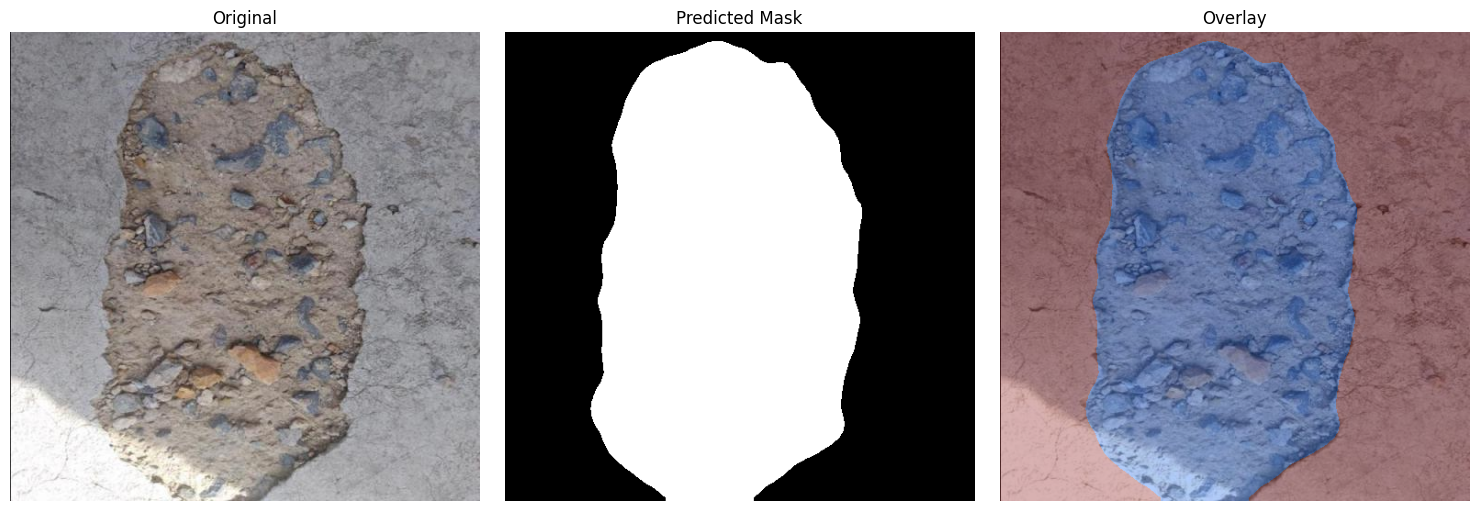

In [ ]:
def visualize_prediction(filename):
    img_path = os.path.join(val_dir, filename)
    mask_path = os.path.join(pred_dir, filename.replace(".jpg", ".png"))

    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    colored_mask = cv2.applyColorMap(mask * 50, cv2.COLORMAP_JET)  # Adjust *50 if needed
    overlay = cv2.addWeighted(image, 0.7, colored_mask, 0.3, 0)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1); plt.imshow(image); plt.title("Original"); plt.axis("off")
    plt.subplot(1, 3, 2); plt.imshow(mask, cmap='gray'); plt.title("Predicted Mask"); plt.axis("off")
    plt.subplot(1, 3, 3); plt.imshow(overlay); plt.title("Overlay"); plt.axis("off")
    plt.tight_layout()
    plt.show()

# Example usage
visualize_prediction(val_images[5])


**Predict & Evaluate Metrics on Validation Set**

In [ ]:
import os
import torch
import numpy as np
import torchvision.transforms.functional as TF
from torchvision.models.segmentation import deeplabv3_resnet50
from PIL import Image
from sklearn.metrics import f1_score, precision_score, recall_score, jaccard_score
from tqdm import tqdm

# === CONFIG ===
model_path = "/content/hust-rebar/best_deeplabv3_weights.pth"
val_image_dir = "/content/aperi-1/valid"
val_mask_dir = "/content/aperi-1/valid_masks"
num_classes = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === 1. Load Model ===
model = deeplabv3_resnet50(num_classes=num_classes)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# === 2. Evaluation Loop ===
all_preds = []
all_gts = []

image_files = sorted([f for f in os.listdir(val_image_dir) if f.endswith(".jpg")])
mask_files = sorted([f for f in os.listdir(val_mask_dir) if f.endswith(".png")])

for img_name, mask_name in tqdm(zip(image_files, mask_files), total=len(image_files)):
    # --- Load image and mask ---
    image = Image.open(os.path.join(val_image_dir, img_name)).convert("RGB")
    mask = Image.open(os.path.join(val_mask_dir, mask_name))

    # Resize if necessary to match training size (e.g., 512×512)
    image = image.resize((512, 512))
    mask = mask.resize((512, 512), resample=Image.NEAREST)

    # Normalize and convert to tensor
    image_tensor = TF.to_tensor(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_tensor)["out"]
        pred = torch.argmax(output.squeeze(), dim=0).cpu().numpy()

    gt = np.array(mask, dtype=np.uint8)

    # Flatten both for metric computation
    all_preds.append(pred.flatten())
    all_gts.append(gt.flatten())

# === 3. Compute Metrics ===
y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_gts)

metrics = {
    "mIoU": jaccard_score(y_true, y_pred, average="macro", zero_division=0),
    "F1-score": f1_score(y_true, y_pred, average="macro", zero_division=0),
    "Precision": precision_score(y_true, y_pred, average="macro", zero_division=0),
    "Recall": recall_score(y_true, y_pred, average="macro", zero_division=0),
}

# Print metrics
print("\n Evaluation Metrics (macro average):")
for k, v in metrics.items():
    print(f"{k:10s}: {v:.4f}")


100%|██████████| 207/207 [00:07<00:00, 29.10it/s]



 Evaluation Metrics (macro average):
mIoU      : 0.3003
F1-score  : 0.3819
Precision : 0.8504
Recall    : 0.3435


**Code (Per-Class Metrics Calculation):**

In [ ]:

from sklearn.metrics import confusion_matrix

def compute_per_class_metrics(y_true, y_pred, num_classes):
    metrics = {'IoU': [], 'F1-score': [], 'Precision': [], 'Recall': []}

    for cls in range(num_classes):
        y_true_cls = (y_true == cls).astype(int)
        y_pred_cls = (y_pred == cls).astype(int)

        tp = np.sum((y_pred_cls == 1) & (y_true_cls == 1))
        fp = np.sum((y_pred_cls == 1) & (y_true_cls == 0))
        fn = np.sum((y_pred_cls == 0) & (y_true_cls == 1))

        precision = tp / (tp + fp + 1e-8)
        recall = tp / (tp + fn + 1e-8)
        f1 = 2 * precision * recall / (precision + recall + 1e-8)
        iou = tp / (tp + fp + fn + 1e-8)

        metrics['IoU'].append(iou)
        metrics['F1-score'].append(f1)
        metrics['Precision'].append(precision)
        metrics['Recall'].append(recall)

    return metrics

# === Collect Predictions & Ground Truths ===
all_preds = []
all_targets = []

model.eval()
with torch.no_grad():
    for images, masks in tqdm(val_loader):
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)['out']
        preds = torch.argmax(outputs, dim=1)

        all_preds.append(preds.cpu().numpy())
        all_targets.append(masks.cpu().numpy())

all_preds = np.concatenate(all_preds, axis=0)
all_targets = np.concatenate(all_targets, axis=0)

# === Compute & Print Per-Class Metrics ===
num_classes = 5
class_names = ['Exposed Rebar', 'Efflorescences', 'Crack', 'Spallings',' Background']
metrics = compute_per_class_metrics(all_targets, all_preds, num_classes)

print("\n Per-Class Metrics:")
for i, name in enumerate(class_names):
    print(f" {name}")
    print(f"   IoU      : {metrics['IoU'][i]:.4f}")
    print(f"   F1-score : {metrics['F1-score'][i]:.4f}")
    print(f"   Precision: {metrics['Precision'][i]:.4f}")
    print(f"   Recall   : {metrics['Recall'][i]:.4f}\n")

100%|██████████| 52/52 [00:06<00:00,  7.56it/s]



 Per-Class Metrics:
 Exposed Rebar
   IoU      : 0.9387
   F1-score : 0.9684
   Precision: 0.9615
   Recall   : 0.9754

 Efflorescences
   IoU      : 0.4801
   F1-score : 0.6487
   Precision: 0.7136
   Recall   : 0.5947

 Crack
   IoU      : 0.4450
   F1-score : 0.6159
   Precision: 0.7714
   Recall   : 0.5126

 Spallings
   IoU      : 0.7070
   F1-score : 0.8284
   Precision: 0.8419
   Recall   : 0.8152

 Background
   IoU      : 0.6751
   F1-score : 0.8060
   Precision: 0.7870
   Recall   : 0.8260



#Refinement of Segmentations with VLM

**Step 1: Overlay Predictions vs. Ground Truth (Visual Verification)**

In [ ]:
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np

def decode_segmap(mask, class_colors):
    """Converts mask (H, W) with class indices to RGB"""
    rgb = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for i, color in enumerate(class_colors):
        rgb[mask == i] = color
    return rgb

def visualize_prediction_vs_groundtruth(model, dataloader, class_colors, device, num_samples=5):
    model.eval()
    shown = 0
    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            outputs = model(images)['out']
            preds = torch.argmax(outputs, dim=1).cpu()
            masks = masks.cpu()

            for i in range(images.size(0)):
                if shown >= num_samples:
                    return

                img = TF.to_pil_image(images[i].cpu())
                pred_mask = preds[i].numpy()
                true_mask = masks[i].numpy()

                pred_rgb = decode_segmap(pred_mask, class_colors)
                true_rgb = decode_segmap(true_mask, class_colors)

                fig, axs = plt.subplots(1, 4, figsize=(16, 4))
                axs[0].imshow(img)
                axs[0].set_title('Original Image')
                axs[1].imshow(true_rgb)
                axs[1].set_title('Ground Truth Mask')
                axs[2].imshow(pred_rgb)
                axs[2].set_title('Predicted Mask')
                axs[3].imshow(img)
                axs[3].imshow(pred_rgb, alpha=0.5)
                axs[3].set_title('Overlay (Pred)')
                for ax in axs:
                    ax.axis('off')
                plt.tight_layout()
                plt.show()

                shown += 1


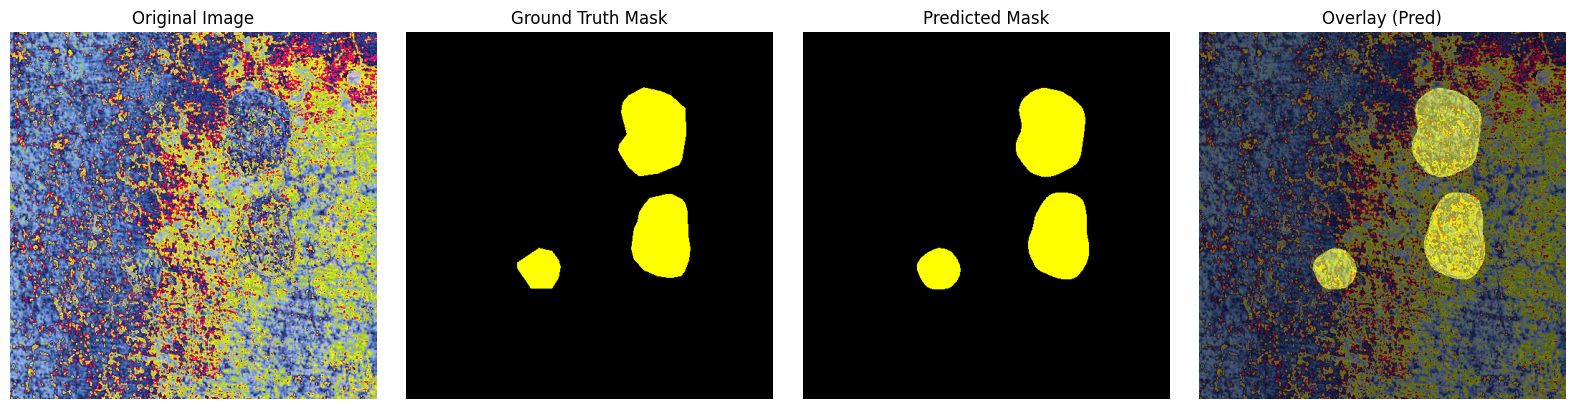

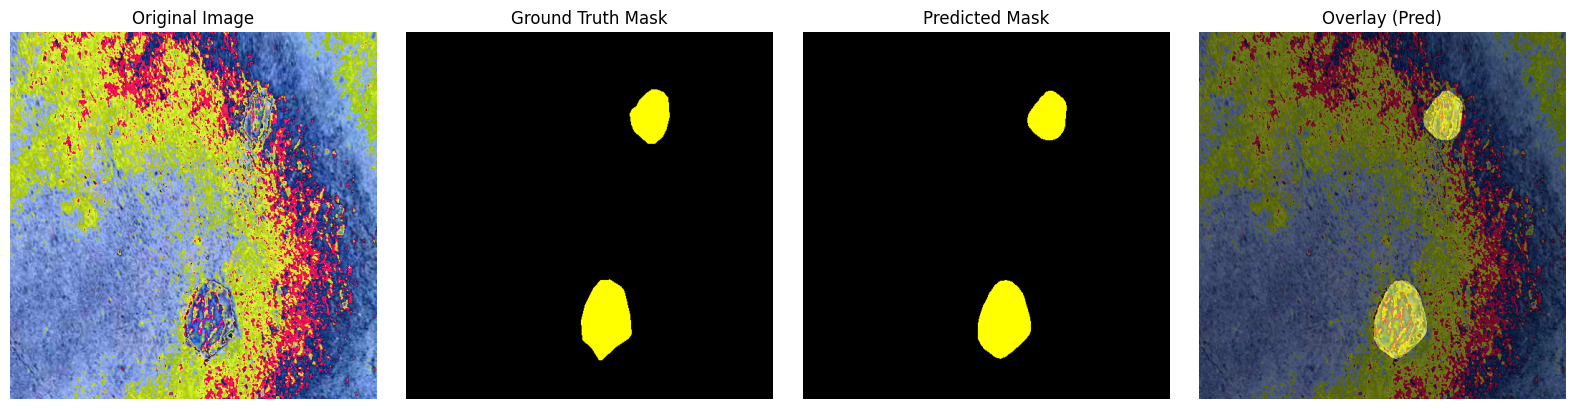

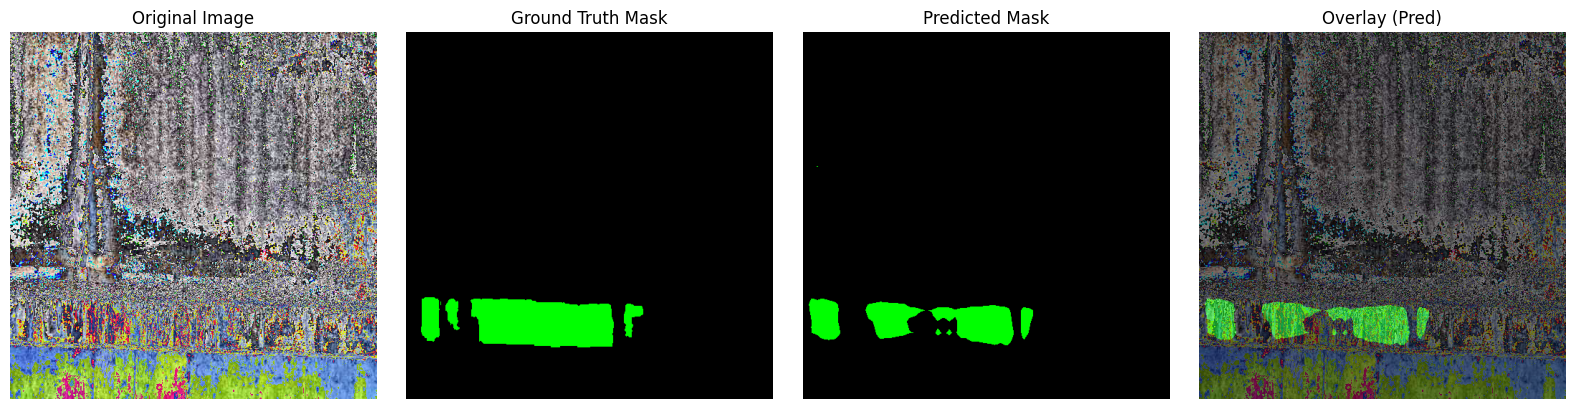

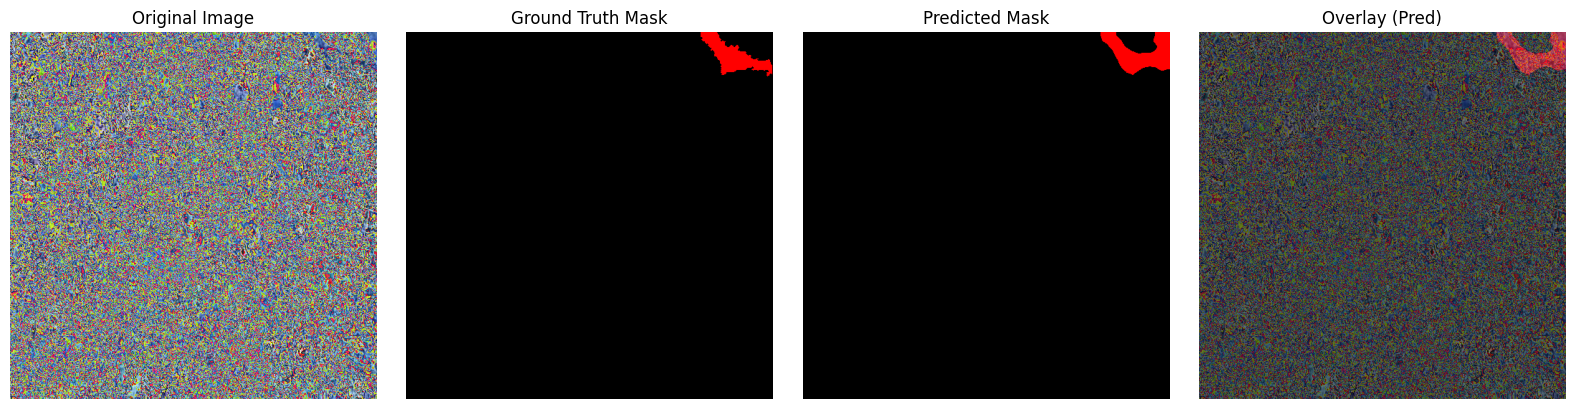

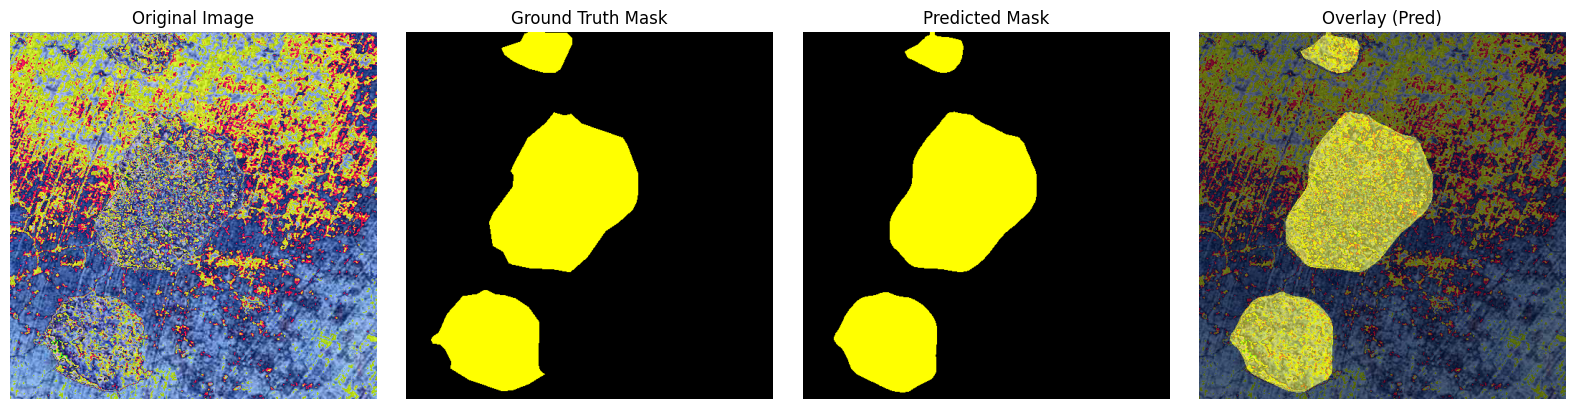

In [ ]:
# Example: 5-class color map (adjust for your dataset)
class_colors = [
    (0, 0, 0),         # Background
    (255, 0, 0),       # Exposed Rebar
    (0, 255, 0),       # Efflorescences
    (0, 0, 255),       # Crack
    (255, 255, 0)      # Spallings
]

visualize_prediction_vs_groundtruth(
    model=model,
    dataloader=val_loader,
    class_colors=class_colors,
    device=device,
    num_samples=5
)


**Step 2: Load CLIP & Compare Predictions to Class Text Descriptions**

In [ ]:
#!pip install --quiet transformers
from transformers import CLIPProcessor, CLIPModel
import torch
from PIL import Image

# Load CLIP model
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

#CLIP similarity per class now.
import numpy as np
from PIL import Image
import torch.nn.functional as F

def get_clip_similarity_for_class_region(image_tensor, pred_mask, class_id, clip_model, clip_processor, text_prompt, device):
    """
    Computes CLIP similarity between masked image and text prompt.
    """
    # Convert tensor image to numpy array HxWxC [0-1]
    img_np = image_tensor.permute(1, 2, 0).cpu().numpy()

    # Create mask for class_id
    mask = (pred_mask == class_id).astype(np.uint8)

    # Mask the image: zero out pixels not belonging to the class
    masked_img_np = img_np.copy()
    for c in range(3):
        masked_img_np[:, :, c] = masked_img_np[:, :, c] * mask

    # Convert to PIL Image
    masked_img = Image.fromarray((masked_img_np * 255).astype(np.uint8))

    # Prepare inputs for CLIP
    inputs = clip_processor(text=[text_prompt], images=masked_img, return_tensors="pt", padding=True).to(device)

    # Compute embeddings and cosine similarity
    outputs = clip_model(**inputs)
    similarity = F.cosine_similarity(outputs.image_embeds, outputs.text_embeds).item()

    return similarity

# Define your class prompts
class_prompts = {
    0: "background or normal concrete",
    1: "an exposed rebar on concrete",
    2: "efflorescences on a surface",
    3: "a crack in concrete",
    4: "spallings on a structure",
}

# Example run on one batch item
sample = next(iter(val_loader))
image_tensor = sample[0][0].to(device)  # first image tensor in batch
pred = model(image_tensor.unsqueeze(0))['out']
pred_mask = torch.argmax(pred, dim=1)[0].cpu().numpy()

print("Class-wise CLIP similarity:")
for class_id in np.unique(pred_mask):
    if class_id == 255:  # ignore void class if any
        continue
    similarity = get_clip_similarity_for_class_region(
        image_tensor,
        pred_mask,
        class_id,
        clip_model,
        clip_processor,
        class_prompts[class_id],
        device,
    )
    print(f"Class {class_id} ({class_prompts[class_id]}): similarity = {similarity:.4f}")




Class-wise CLIP similarity:
Class 0 (background or normal concrete): similarity = 0.2467
Class 4 (spallings on a structure): similarity = 0.2197
